# Google Package Download Counts

_Displays the download count for all Google-owned packages hosted on [PyPI](https://pypi.org/) i.e. how frequently each package is installed using PIP_

While PyPI download statistics are hosted in BigQuery, the ownership of the packages is not accessable through BigQuery. So there process is:

1. Fetch the download statistics for all packages from BigQuery
2. Fetch the home page URL of each package from the PyPI JSON API
3. Filter out the packages whose home page URL is not `github.com/google...`
4. Display a plot of the download frequency of each package

In [1]:
%load_ext google.cloud.bigquery

In [2]:
%matplotlib inline

In [3]:
import json
import pandas
import urllib.error
import urllib.parse
import urllib.request


In [4]:
%%bigquery pip_packages
SELECT file.project, COUNT(*) AS num_downloads
FROM `the-psf.pypi.downloads*`
GROUP BY file.project;

,project,num_downloads
0,jobbybot-rit-jobzone,256
1,sdlib-v0-4,256
2,param-types,256
3,jnestertest,256
4,miscprom,256
5,django-graphql-admin,256
6,stonesthrow,256
7,pydda,256
8,odoo12-addon-mail-debrand,256
9,tf-agents-nightly,256


In [5]:
def get_home_page(pip_package):
    url = 'https://pypi.org/pypi/{0}/json'.format(pip_package)
    try:
        info = json.loads(urllib.request.urlopen(url).read())['info']
    except urllib.error.HTTPError as e:
        if e.code == 404:
            return None
        raise
    if 'home_page' in info:
        return info['home_page']
    return None

In [6]:
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(100) as t:
    pip_packages['home_page'] = list(
        t.map(lambda r: get_home_page(r.project),
              pip_packages.itertuples()))

In [7]:
def home_page_to_repo(home_page):
    if home_page:
        p = urllib.parse.urlparse(home_page)
        if 'http' in p.scheme and 'github.com' == p.netloc and p.path.count('/') > 1:
            return '/'.join(p.path[1:].split('/')[:2])

In [8]:
pip_packages['repo'] = list(map(lambda r: home_page_to_repo(r.home_page),
                                pip_packages.itertuples()))

In [9]:
google_packages_and_downloads = sorted(
    ((row.project, row.num_downloads)
     for row in pip_packages.itertuples()
     if row.repo and row.repo.lower().startswith('google')),
    key=lambda v: v[1])

In [11]:
data = pandas.DataFrame.from_records(
    google_packages_and_downloads,
    index='packages',
    columns=['packages', 'downloads'])

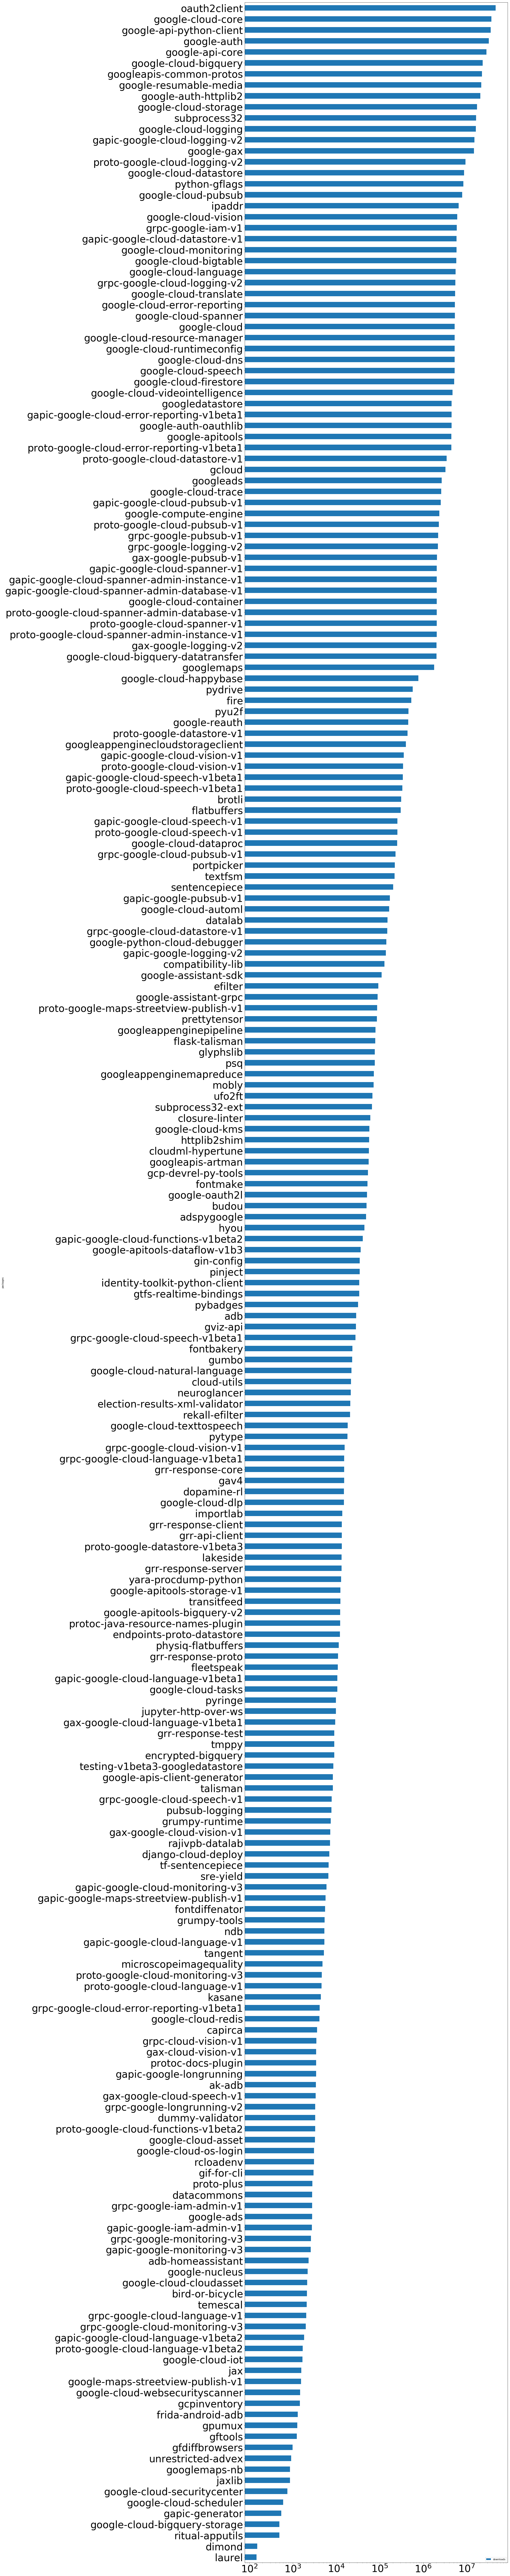

In [18]:
data.plot(kind='barh', logx=True, figsize=(20, 200), fontsize=42)